In [233]:
from __future__ import annotations
import numpy as np
import pandas as pd
from scipy.stats import gamma
import seaborn as sns
import umap
import pprint
import matplotlib.pyplot as plt
import networkx as nx
from typing import Optional, Dict, Tuple, List, Union
from sklearn import set_config
import matplotlib.cm as cm
set_config(display="diagram")   # 再び図表示を有効化（1.4 系なら安全）



In [234]:
__all__ = [
    "generate_weight_matrix",
    "simulate_network",
]

### 遺伝子の数と重みに関わるマトリクスの作成

In [235]:
def generate_weight_matrix(
    n_genes: int = 10,
    shape: float = 2.0,
    scale: float = 1.0,
    allow_self_loop: bool = False,
    sparsity: float = 0.2,  # ← 80%がゼロ
    random_state: Optional[int] = None,
) -> np.ndarray:
    rng = np.random.default_rng(random_state)
    W = rng.gamma(shape, scale, size=(n_genes, n_genes))
    sign = rng.choice([-1.0, 1.0], size=(n_genes, n_genes))
    W *= sign

    # スパース化
    mask = rng.random((n_genes, n_genes)) > sparsity
    W *= mask

    if not allow_self_loop:
        np.fill_diagonal(W, 0.0)
    return W


In [236]:
_DEF_BETA = 4.0

def _sigmoid(x: np.ndarray, beta: float = _DEF_BETA) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-beta * x))


In [237]:
def simulate_network(
    W: np.ndarray,
    *,
    perturb_gene: Optional[int] = None,
    perturb_value: float = 1.0,
    n_steps: int = 2000,
    dt: float = 0.05,
    noise_std: float = 0.05,
    beta: float = _DEF_BETA,
    threshold: float = 0.5,
    n_runs: int = 1000,
    random_state: Optional[int] = None,
    return_states: bool = False,
    return_trajectories: bool = False,
) -> Union[
    Dict[Tuple[int, ...], float],
    Tuple[Dict[Tuple[int, ...], float], List[Tuple[int, ...]]],
    Tuple[Dict[Tuple[int, ...], float], List[Tuple[int, ...]], List[np.ndarray]],
]:
    rng = np.random.default_rng(random_state)
    n_genes = W.shape[0]

    counts: Dict[Tuple[int, ...], int] = {}
    states: List[Tuple[int, ...]] = [] if return_states else None  # type: ignore
    trajectories: List[np.ndarray] = [] if return_trajectories else None  # type: ignore

    for _ in range(n_runs):
        x = rng.random(n_genes)  # initial expression 0–1
        if perturb_gene is not None:
            x[perturb_gene] = np.clip(x[perturb_gene] + perturb_value, 0.0, 1.0)

        if return_trajectories:
            traj = np.zeros((n_steps, n_genes))

        for t in range(n_steps):
            dx = -x + _sigmoid(W @ x, beta)
            x += dt * dx + noise_std * np.sqrt(dt) * rng.standard_normal(n_genes)
            x = np.clip(x, 0.0, 1.0)
            if return_trajectories:
                traj[t] = x

        bin_state: Tuple[int, ...] = tuple((x > threshold).astype(int))
        counts[bin_state] = counts.get(bin_state, 0) + 1
        if return_states:
            states.append(bin_state)  # type: ignore[arg-type]
        if return_trajectories:
            trajectories.append(traj)

    total = float(n_runs)
    probs = {state: c / total for state, c in counts.items()}

    if return_states and return_trajectories:
        return probs, states, trajectories
    elif return_states:
        return probs, states
    elif return_trajectories:
        return probs, trajectories
    else:
        return probs


In [238]:
def plot_expression_heatmap(final_states: np.ndarray, title: str = "Final Expression State per Run"):
    """
    final_states: np.ndarray of shape (n_runs, n_genes)
    title: plot title
    """
    plt.figure(figsize=(20, 6))
    sns.heatmap(final_states, cmap="viridis", cbar=True)

    plt.title(title, fontsize=14)
    plt.xlabel("Gene", fontsize=12)
    plt.ylabel("Run", fontsize=12)

    # Y軸（Runインデックス）ラベルを90度回転
    plt.yticks(rotation=360)
    plt.tight_layout()
    plt.show()

In [267]:
def simulate_perturbation(x0, W, pert_gene, mode="KO", n_steps=30, beta=4.0):
    """
    x0 : 初期発現ベクトル (連続値 0-1)
    pert_gene : 摂動対象の gene ID
    mode : "KO" (0 に固定) / "OE" (1 に固定) / "delta" (+0.5 など)
    """
    x = x0.copy()
    if mode == "KO":
        x[pert_gene] = 0.0
    elif mode == "OE":
        x[pert_gene] = 1.0
    elif isinstance(mode, (float, int)):     # delta
        x[pert_gene] = np.clip(x[pert_gene] + mode, 0, 1)

    traj = np.zeros((n_steps, len(x)))
    for t in range(n_steps):
        x = step_update(x, W, beta)
        traj[t] = x
    return traj

In [268]:
def step_update(x, W, beta=4.0):
    """1 ステップ更新: sigmoid(Wx) を Euler–Maruyama の決定項に対応させる"""
    return 1.0 / (1.0 + np.exp(-beta * (W @ x)))

In [269]:
def perturbation_score(pos, vel, traj_emb):
    """
    pos, vel : 基準ベクトル場 (UMAP 2D に射影済み)
    traj_emb : 摂動軌跡を同じ UMAP で射影した 2D 座標配列
    """
    v_ref = (pos[1:] - pos[:-1]).mean(0)
    v_sim = traj_emb[-1] - traj_emb[0]
    return np.dot(v_ref, v_sim) / (np.linalg.norm(v_ref)*np.linalg.norm(v_sim))

In [270]:
from sklearn.linear_model import RidgeCV

def learn_grn_ridge(X_expr: np.ndarray,
                    alpha_grid: list[float] | None = None,
                    cv: int = 5) -> np.ndarray:
    """
    X_expr : shape (cells, genes)
    return : shape (genes, genes)  (行 = ターゲット, 列 = TF)
    """
    n_cells, n_genes = X_expr.shape
    W_hat = np.zeros((n_genes, n_genes))

    # α 値を自動探索するグリッド（なければデフォルト）
    if alpha_grid is None:
        alpha_grid = [0.1, 1.0, 10.0]

    for tgt in range(n_genes):
        mask = np.ones(n_genes, bool)
        mask[tgt] = False
        X_tf = X_expr[:, mask]
        y    = X_expr[:, tgt]

        ridge = RidgeCV(alphas=alpha_grid, cv=cv).fit(X_tf, y)
        beta  = ridge.coef_

        W_hat[tgt, mask] = beta
    return W_hat


Weight matrix:
 [[-2.09181727 -0.         -0.          1.64507042  0.         -1.75337354
  -2.34600508  0.          3.07741359  0.        ]
 [ 3.79558385  0.         -0.         -0.          0.          0.
  -0.          0.81277693 -2.82212535  0.56580366]
 [ 0.94667552 -1.8218915  -3.06379062 -2.70575901  0.          0.
  -1.13018268 -1.3360964   0.78014998 -0.30137816]
 [-0.         -2.76379198  1.25578429  0.         -0.50266276  0.
   1.85738208 -0.          2.6117788   2.32864297]
 [-1.24052934 -0.55046145  1.13114983  2.36753463 -2.68170571  0.
   0.29953879 -0.47585799  2.23787909 -1.2245784 ]
 [ 1.2477426  -0.72857239 -0.71644203  0.         -2.29276523  1.01127648
  -1.76153045  1.98545782  4.70768776  0.66376046]
 [-1.96711948 -2.9939697   4.35942502  0.9696665   1.21237564 -2.62846619
   0.39767373 -2.10505901 -5.80179977  2.26095375]
 [-0.15137741  0.82204223 -0.99476141 -3.45636287 -1.47014378  0.30477054
   1.59819342  1.84057093  0.          0.70539973]
 [ 0.          3

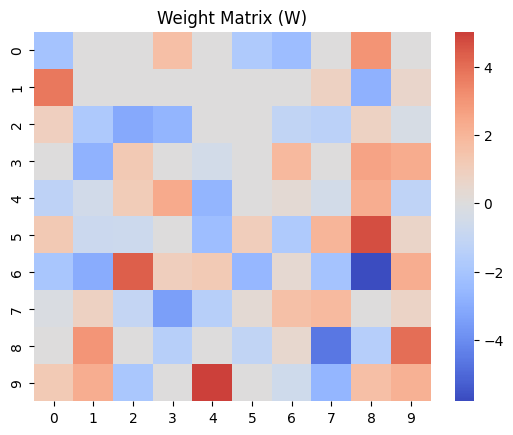

In [239]:
W = generate_weight_matrix(n_genes=10, random_state=42,sparsity=0.2,allow_self_loop=True)
print("Weight matrix:\n", W)
sns.heatmap(W, cmap='coolwarm', center=0)
plt.title("Weight Matrix (W)")
plt.show()

In [240]:
probs, states, trajs = simulate_network(
    W,
    perturb_gene=1,
    perturb_value=1.0,
    n_runs=1000,
    n_steps=50,
    return_states=True,
    return_trajectories=True,
    random_state=42
)


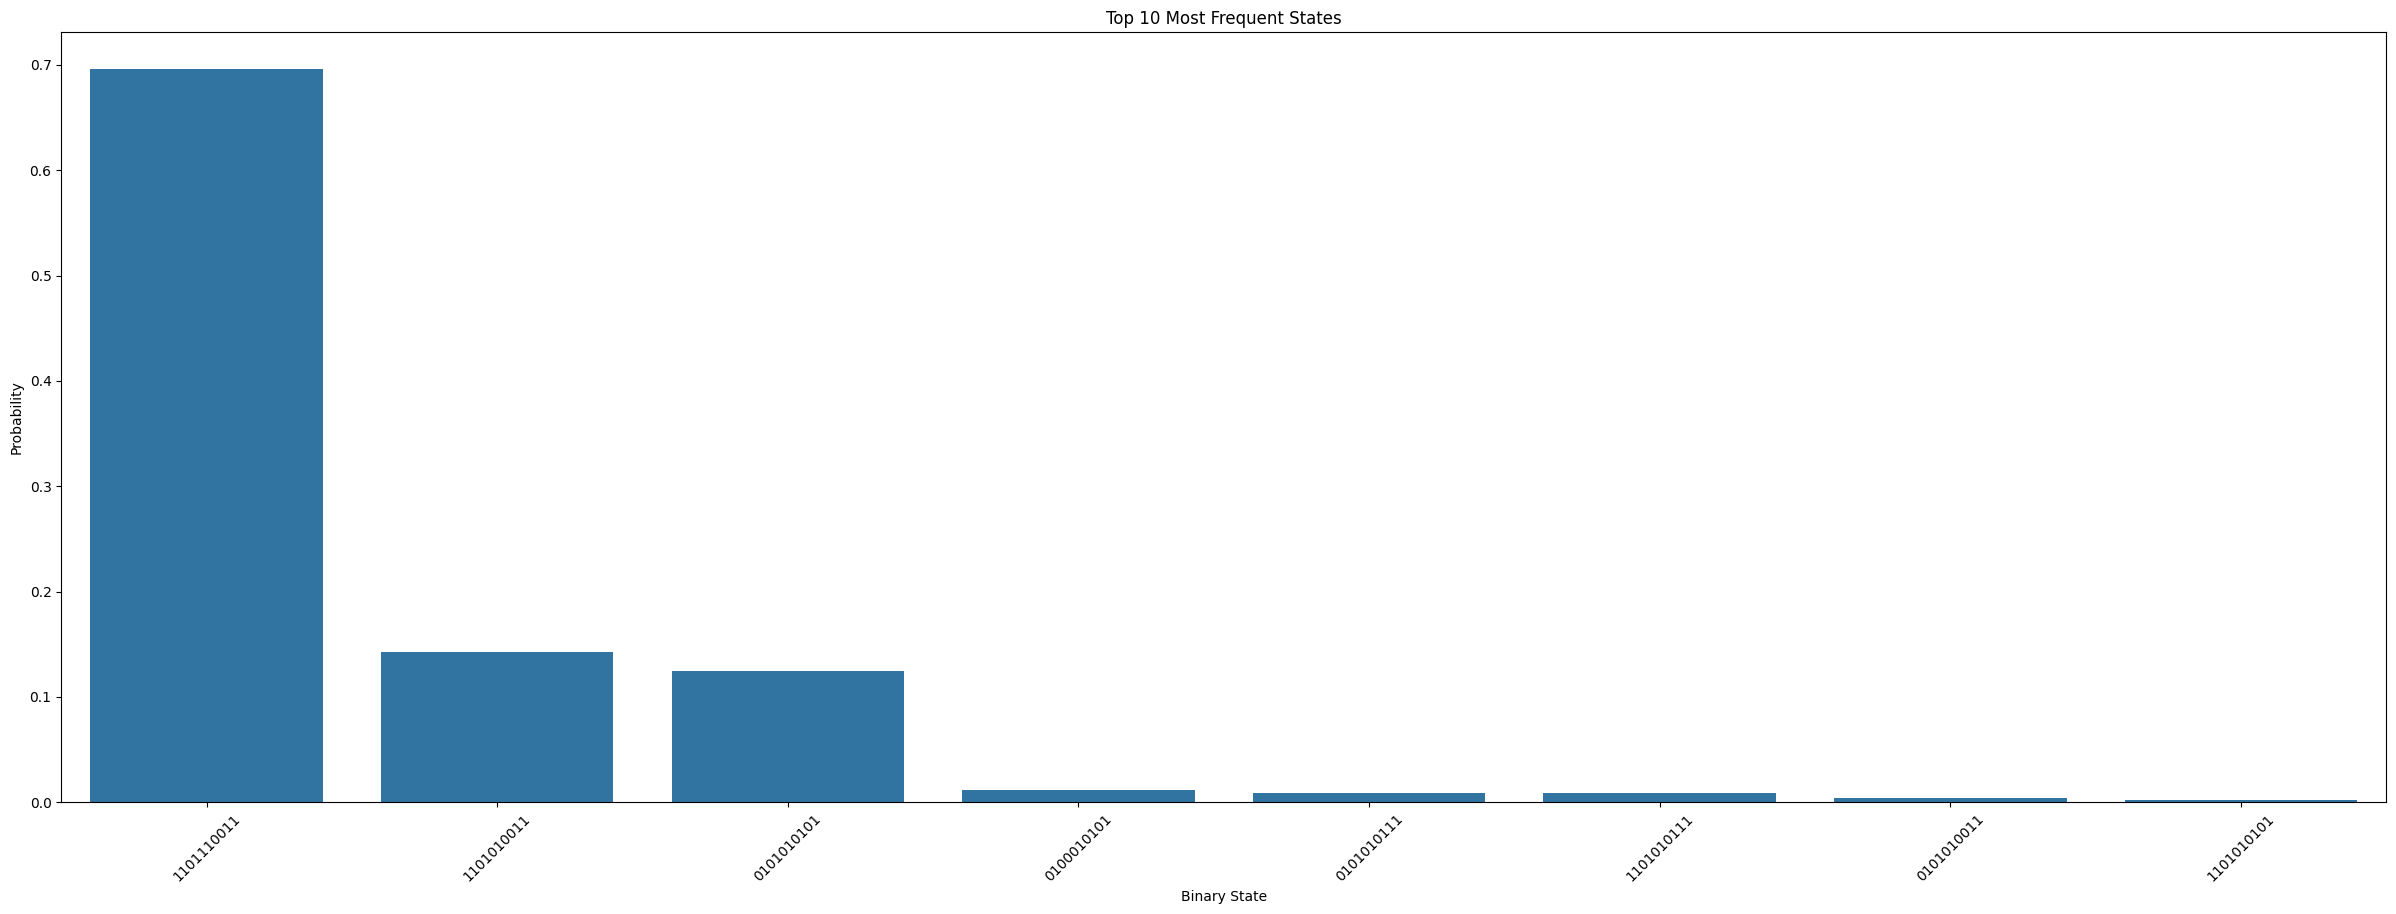

In [241]:
sorted_probs = sorted(probs.items(), key=lambda x: x[1], reverse=True)
top_states = sorted_probs[:10]

labels = ["".join(map(str, k)) for k, _ in top_states]
values = [v for _, v in top_states]

plt.figure(figsize=(30,10))
sns.barplot(x=labels, y=values)
plt.xticks(rotation=45)
plt.title("Top 10 Most Frequent States")
plt.ylabel("Probability")
plt.xlabel("Binary State")
plt.show()


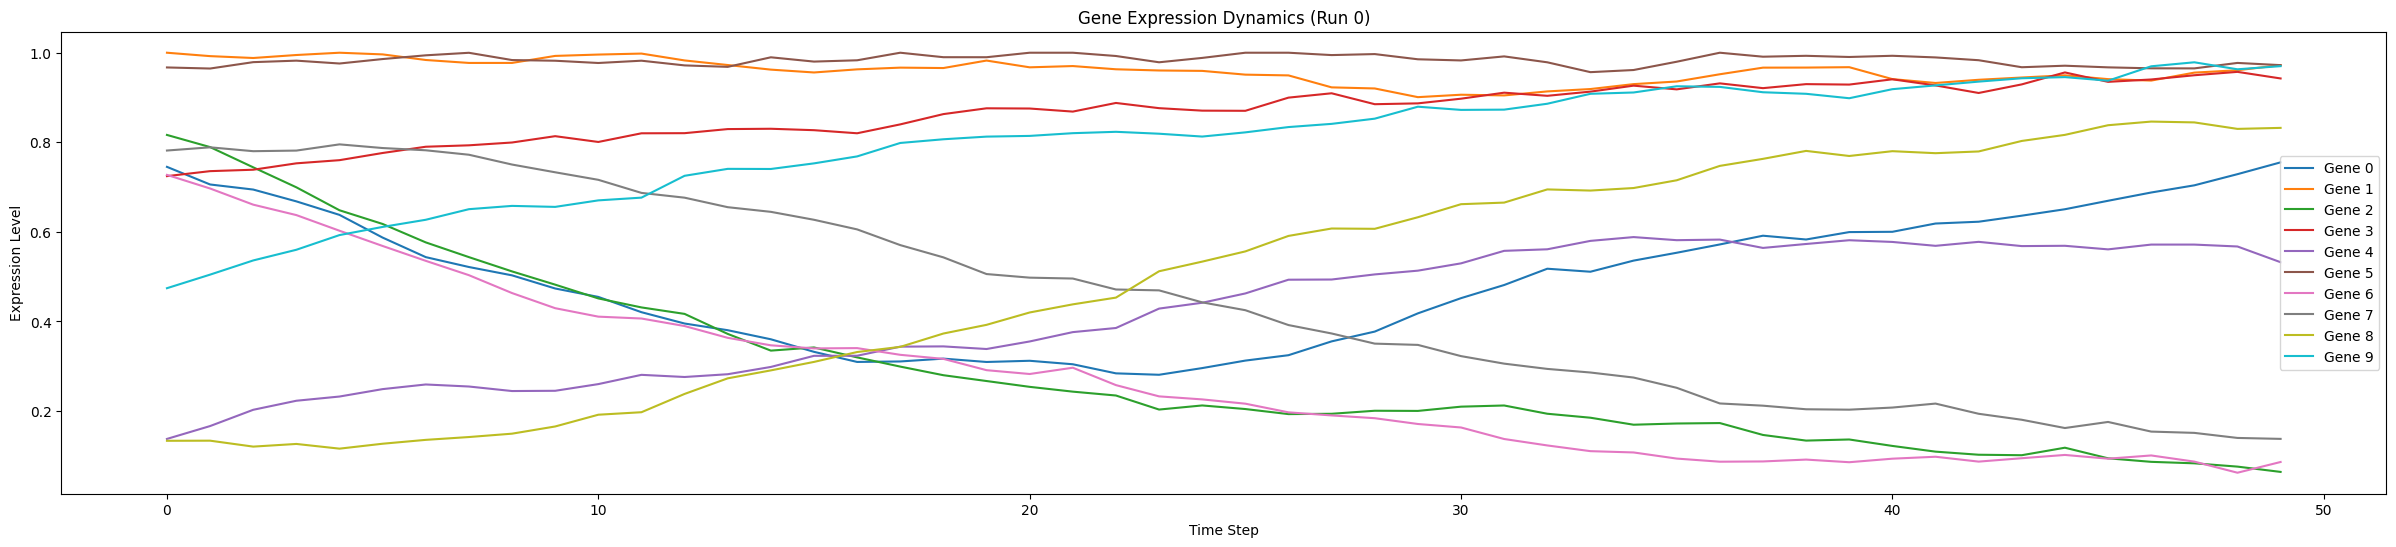

In [242]:
run_index = 0
data = trajs[run_index]

plt.figure(figsize=(30,6))
for gene in range(data.shape[1]):
    plt.plot(data[:, gene], label=f"Gene {gene}")
plt.title("Gene Expression Dynamics (Run 0)")
plt.xlabel("Time Step")
plt.ylabel("Expression Level")
plt.legend()
plt.show()


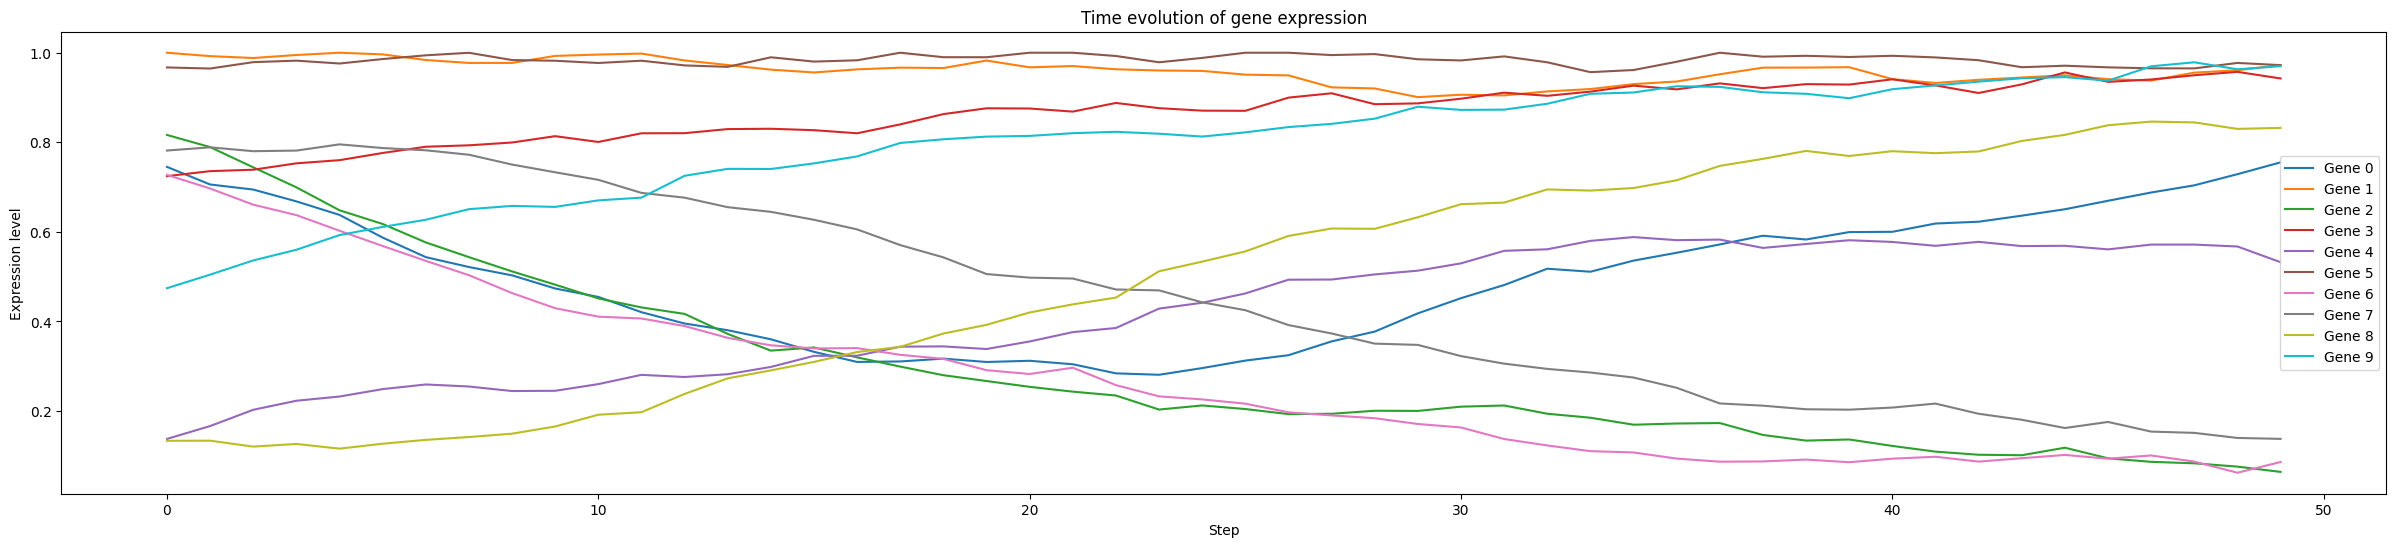

In [243]:
plt.figure(figsize=(30,6))
for g in range(W.shape[0]):
    plt.plot(trajs[0][:, g], label=f"Gene {g}")
plt.title("Time evolution of gene expression")
plt.xlabel("Step")
plt.ylabel("Expression level")
plt.legend()
plt.show()


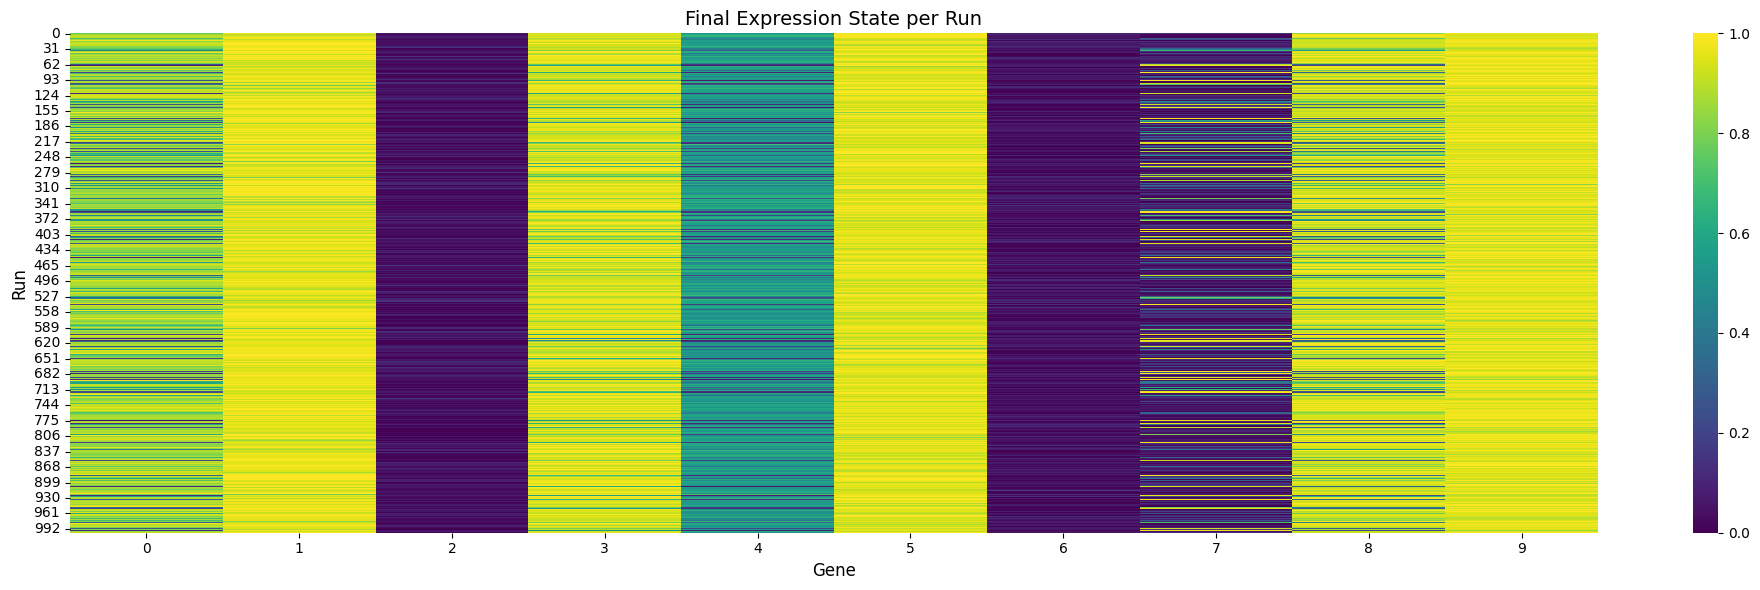

In [244]:
final_states = np.array([traj[-1] for traj in trajs])
plot_expression_heatmap(final_states=final_states)

In [245]:
X_continuous = np.array([traj[-1] for traj in trajs])
X_binary = np.array(states).astype(int)

In [246]:
pd.DataFrame(X_continuous)

,0,1,2,3,4,5,6,7,8,9
0,0.755180,0.972175,0.063880,0.942535,0.532162,0.972276,0.086018,0.137630,0.832154,0.970038
1,0.873027,1.000000,0.080168,0.922074,0.492511,0.980523,0.026730,0.205914,0.933481,0.932389
2,0.857196,0.891390,0.020267,0.923213,0.601850,0.989447,0.096835,0.012037,0.972782,0.945207
3,0.864066,0.969896,0.022800,0.958291,0.511555,0.893697,0.025756,0.073072,0.926704,0.998216
4,0.895792,0.919405,0.042796,0.950656,0.658242,0.994554,0.053045,0.031110,0.980599,0.942957
...,...,...,...,...,...,...,...,...,...,...
995,0.120145,0.978959,0.033778,0.529737,0.089281,0.946812,0.029842,0.976773,0.219359,0.857099
996,0.880471,0.946506,0.043748,0.923403,0.567381,0.929818,0.000000,0.064986,0.936745,0.911491
997,0.843192,0.918858,0.079369,0.914383,0.604247,0.915908,0.040613,0.028619,0.920967,0.925119
998,0.665203,0.936822,0.013248,0.936093,0.485949,0.957925,0.068408,0.218886,0.748592,0.922728


In [247]:
pd.DataFrame(X_binary)

,0,1,2,3,4,5,6,7,8,9
0,1,1,0,1,1,1,0,0,1,1
1,1,1,0,1,0,1,0,0,1,1
2,1,1,0,1,1,1,0,0,1,1
3,1,1,0,1,1,1,0,0,1,1
4,1,1,0,1,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
995,0,1,0,1,0,1,0,1,0,1
996,1,1,0,1,1,1,0,0,1,1
997,1,1,0,1,1,1,0,0,1,1
998,1,1,0,1,0,1,0,0,1,1


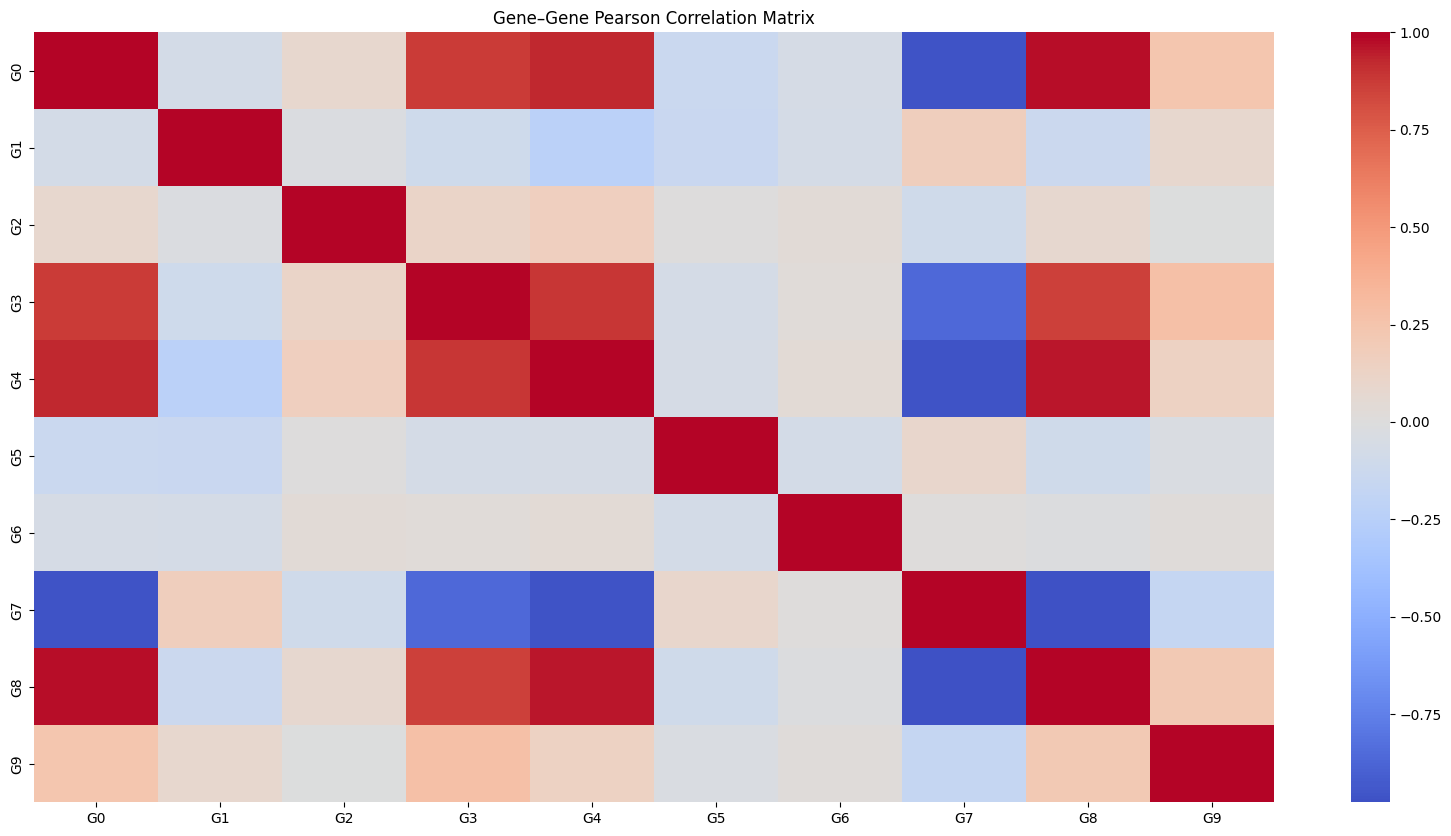

In [248]:
df_expr = pd.DataFrame(X_continuous, columns=[f"G{i}" for i in range(X_continuous.shape[1])])
corr = df_expr.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr, center=0, cmap="coolwarm")
plt.title("Gene–Gene Pearson Correlation Matrix")
plt.show()

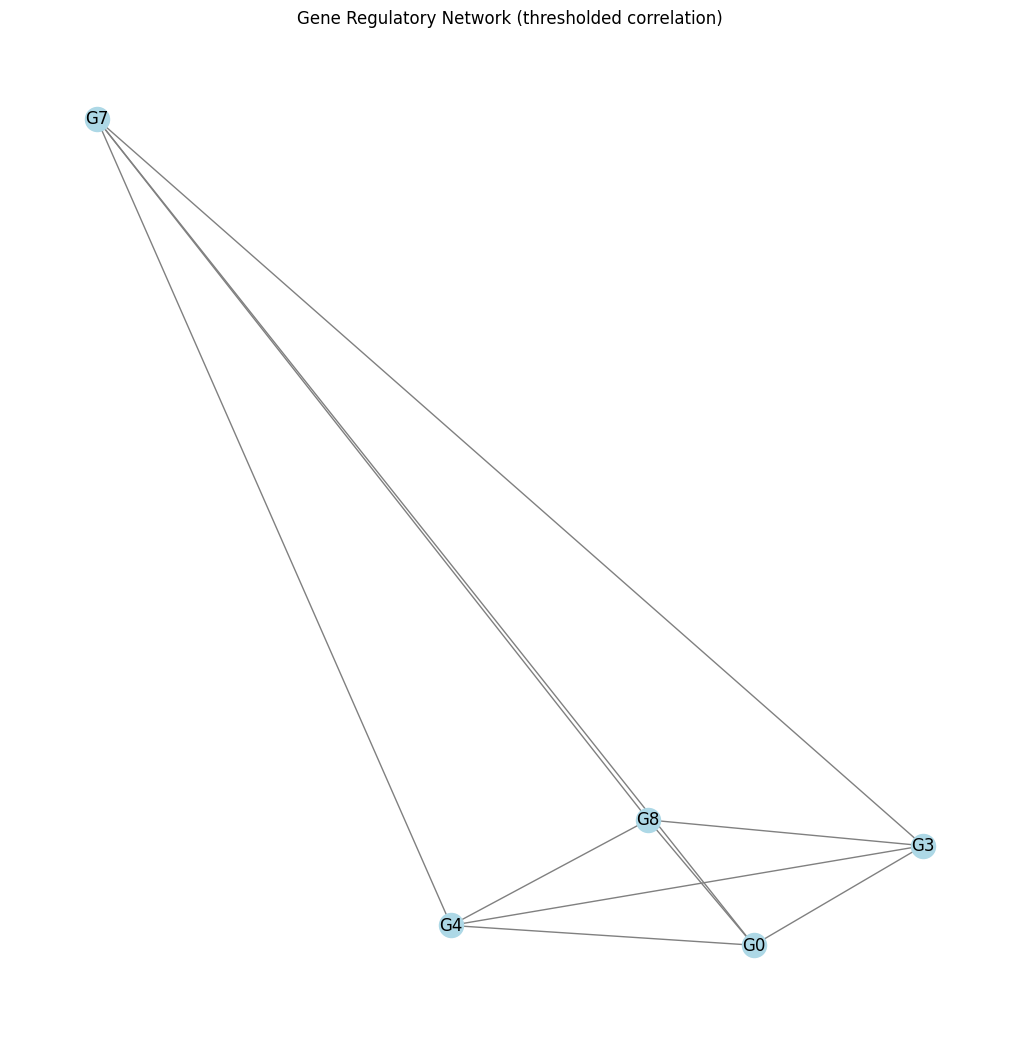

In [249]:
import networkx as nx

G = nx.Graph()

# 閾値以上の相関にエッジを追加（例）
threshold = 0.6
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[1]):
        if abs(corr.iloc[i, j]) > threshold:
            G.add_edge(f"G{i}", f"G{j}", weight=corr.iloc[i, j])

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
plt.title("Gene Regulatory Network (thresholded correlation)")
plt.show()


In [255]:
pd.DataFrame(X_continuous)

,0,1,2,3,4,5,6,7,8,9
0,0.755180,0.972175,0.063880,0.942535,0.532162,0.972276,0.086018,0.137630,0.832154,0.970038
1,0.873027,1.000000,0.080168,0.922074,0.492511,0.980523,0.026730,0.205914,0.933481,0.932389
2,0.857196,0.891390,0.020267,0.923213,0.601850,0.989447,0.096835,0.012037,0.972782,0.945207
3,0.864066,0.969896,0.022800,0.958291,0.511555,0.893697,0.025756,0.073072,0.926704,0.998216
4,0.895792,0.919405,0.042796,0.950656,0.658242,0.994554,0.053045,0.031110,0.980599,0.942957
...,...,...,...,...,...,...,...,...,...,...
995,0.120145,0.978959,0.033778,0.529737,0.089281,0.946812,0.029842,0.976773,0.219359,0.857099
996,0.880471,0.946506,0.043748,0.923403,0.567381,0.929818,0.000000,0.064986,0.936745,0.911491
997,0.843192,0.918858,0.079369,0.914383,0.604247,0.915908,0.040613,0.028619,0.920967,0.925119
998,0.665203,0.936822,0.013248,0.936093,0.485949,0.957925,0.068408,0.218886,0.748592,0.922728


In [271]:
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
).fit(X_continuous)    

/usr/local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [272]:
embedding_base = reducer.transform(X_continuous)  

/usr/local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


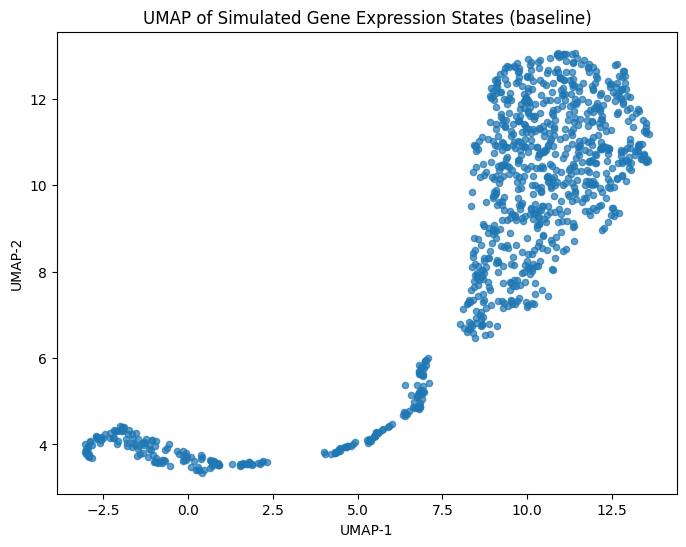

In [273]:
plt.figure(figsize=(8, 6))
plt.scatter(embedding_base[:, 0], embedding_base[:, 1], s=20, alpha=0.7)
plt.title("UMAP of Simulated Gene Expression States (baseline)")
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2"); plt.show()

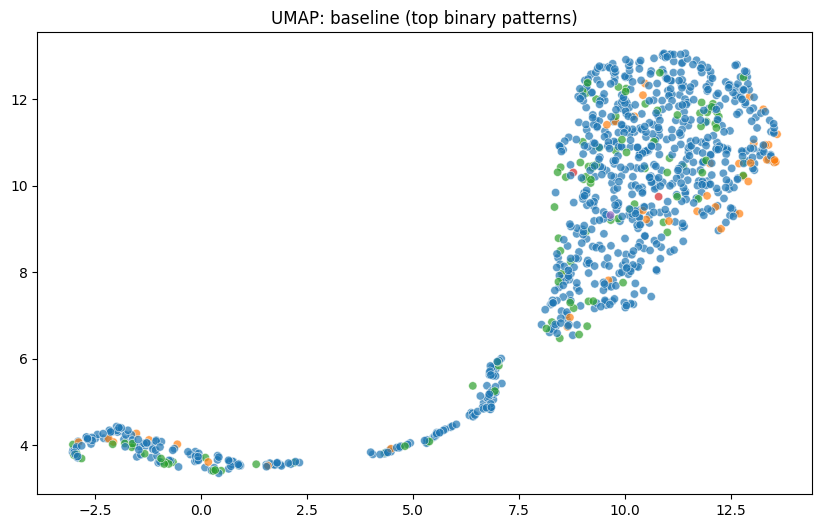

In [274]:
labels = ["".join(map(str, s)) for s in states]
top_labels = pd.Series(labels).value_counts().index[:10]
colors = [lab if lab in top_labels else "other" for lab in labels]

plt.figure(figsize=(10, 6))
sns.scatterplot(x=embedding_base[:, 0], y=embedding_base[:, 1],
                hue=colors, palette="tab10", alpha=0.7, legend=False)
plt.title("UMAP: baseline (top binary patterns)")
plt.show()

In [276]:
W_hat  = learn_grn_ridge(X_continuous)
scale  = np.quantile(np.abs(W_hat[W_hat!=0]), 0.99) if (W_hat!=0).any() else 1
W_used = np.clip(W_hat/scale, -1, 1)                 # 正規化済み学習 GRN


In [277]:
x0        = X_continuous.mean(axis=0)
traj_KO   = simulate_perturbation(x0, W_used, pert_gene=3, mode="KO", n_steps=30)
traj_KO_2d = reducer.transform(traj_KO)

# 簡易 Perturbation Score (cos θ)
v_ref = (embedding_base[1:] - embedding_base[:-1]).mean(0)
v_sim = traj_KO_2d[-1] - traj_KO_2d[0]
PS    = (v_ref @ v_sim) / (np.linalg.norm(v_ref)*np.linalg.norm(v_sim))
print(f"Perturbation Score (Gene-3 KO): {PS:.3f}")

Perturbation Score (Gene-3 KO): 0.698


/usr/local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


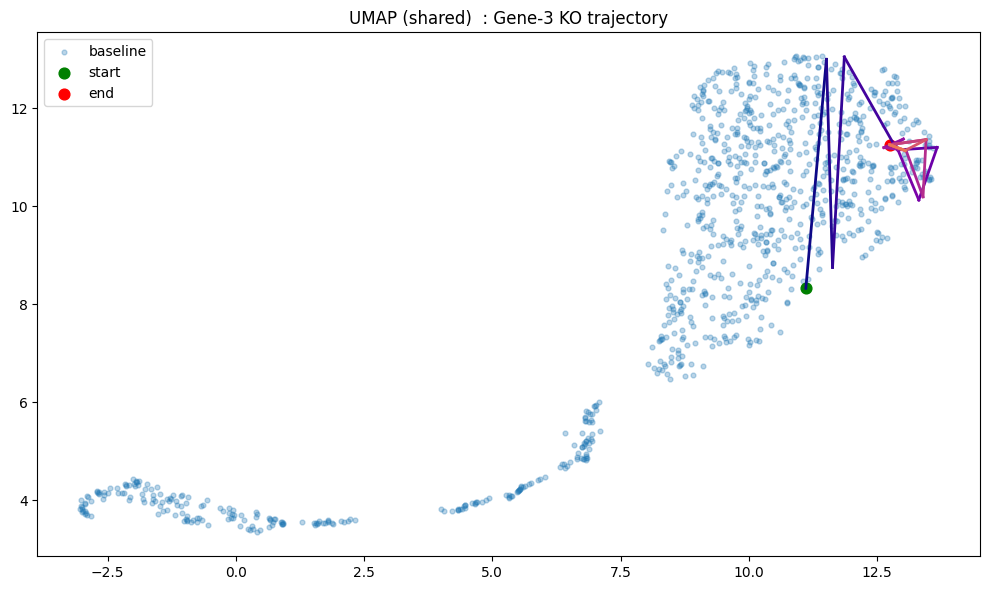

In [279]:
plt.figure(figsize=(10,6))
plt.scatter(embedding_base[:,0], embedding_base[:,1],
            s=12, alpha=0.3, label="baseline")
cmap = cm.plasma(np.linspace(0,1,len(traj_KO_2d)))
for i in range(len(traj_KO_2d)-1):
    plt.plot(traj_KO_2d[i:i+2,0], traj_KO_2d[i:i+2,1], color=cmap[i], lw=2)
plt.scatter(traj_KO_2d[0,0], traj_KO_2d[0,1], c="green", s=60, label="start")
plt.scatter(traj_KO_2d[-1,0], traj_KO_2d[-1,1], c="red", s=60, label="end")
plt.title("UMAP (shared)  : Gene-3 KO trajectory")
plt.legend(); plt.tight_layout(); plt.show()